## DCGAN のデモンストレーション
### MNISTのデータセットを利用し、GANから手書き数字画像を生成させるコードです。

In [1]:
#必要なライブラリのインポート

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [3]:
# MNISTデータセットのロード

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

#前処理(32bitフロートへの変換、ノーマライズ(-1, 1))

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
#バッチサイズの定義、データセットへの反映

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
# Generatorの定義　資料P7

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
 
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
 
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
 
    return model

generator = make_generator_model()

In [6]:
# ランダムベクトルの生成

noise = tf.random.normal([1, 100])

noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.2406522e+00, -6.2604785e-02,  1.5239455e-01, -9.0884231e-03,
        -4.3446422e-01, -1.6734284e+00, -4.6960083e-01,  7.4083650e-01,
         1.0226780e+00, -1.0005450e-01, -2.4079332e-01,  2.3828992e-01,
         4.2139116e-01, -2.7446908e-01, -1.1680804e+00,  2.2457728e+00,
        -1.1205016e-01, -1.6034429e+00, -8.1509507e-01, -2.5465801e+00,
         2.0275582e-01, -8.7227398e-01,  1.0305885e+00, -8.5864437e-01,
        -9.2407662e-01,  2.0742543e+00, -5.4566151e-01, -5.3255439e-01,
        -1.1569116e+00,  1.6066159e-01, -3.5737866e-01,  6.2918806e-01,
        -7.4181670e-01,  1.3139030e-01, -2.0975038e-01, -1.4846683e-01,
        -6.4837402e-01, -3.8866380e-01,  5.8253717e-01,  2.4112940e+00,
         8.8555568e-01,  2.8448817e-03, -1.3669996e-01,  1.9269347e+00,
        -1.1622969e+00, -4.7433817e-01,  6.4670309e-02,  3.0272239e-01,
        -4.4750851e-01, -7.0622748e-01, -4.6050289e-01,  1.5913845e+00,
        -4.822

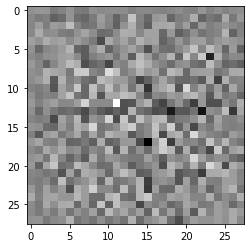

In [7]:
# 学習前のGeneratorでランダムベクトルから画像生成

generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
# discriminatorの定義

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
 
    return model


discriminator = make_discriminator_model()

In [9]:
#損失関数の定義

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
# Discriminatorの損失の定義

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generatorの損失の定義

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
# 最適化アルゴリズムの定義
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
# ランダムベクトルの生成

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# 学習サイクルの定義

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
 
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
 
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [14]:
#チェックポイントと画像保存の定義

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      train_step(image_batch)
 
    # GIF画像として保存
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
 
    # チェックポイントは15エポック毎に保存
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # 最終エポック後に生成
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4,4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()



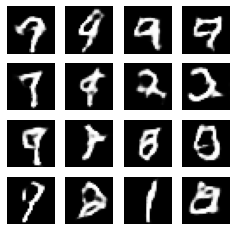

In [15]:
# 学習の実行

EPOCHS = 50
train(train_dataset, EPOCHS)
